<a href="https://colab.research.google.com/github/jonathan-schwarz/TxGNNv2/blob/main/analyse_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title
!pip install -q accelerate
!pip install -q bitsandbytes
!pip install -q chardet
!pip install -q goatools
!pip install -q gpytorch
!pip install -q matplotlib
!pip install -q numpy
!pip install -q peft
!pip install -q seaborn
!pip install -q scikit-learn
!pip install -q tqdm
!pip install -q transformers[torch]
!pip install -q trl
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8

In [80]:
#@title Imports & Setup

import collections
import gpytorch
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import wandb

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import GridInterpolationVariationalStrategy, UnwhitenedVariationalStrategy
from scipy.stats import entropy
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = '/content/gdrive/My Drive/Work/Harvard/TxGNN/Data'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
#@title Data

device =  torch.device('cuda:0') if torch.cuda.is_available() else torch.device( "cpu")

dataset = 'did'
DD_TYPES = {
    'did': 'drug_indication_disease',
    'dod': 'drug_off-label use_disease',
    'dcd': 'drug_contraindication_disease',
    'drid': 'disease_rev_indication_drug',
    'drod': 'disease_rev_off-label use_drug',
    'drcd': 'disease_rev_contraindication_drug',
}

data = np.load(os.path.join(DATA_PATH, '{}.npz').format(DD_TYPES[dataset]))

train_x = torch.Tensor(np.concatenate(
    [data['train_h_u'], data['train_h_v']], axis=1)).to(device)
train_y = torch.Tensor(data['train_labels']).to(device)
train_names = np.concatenate(
    [data['train_u_names'], data['train_v_names']], axis=1)
train_set = torch.utils.data.TensorDataset(train_x, train_y)

valid_x = torch.Tensor(np.concatenate(
    [data['valid_h_u'], data['valid_h_v']], axis=1)).to(device)
valid_y = torch.Tensor(data['valid_labels']).to(device)
valid_names = np.concatenate(
    [data['valid_u_names'], data['valid_v_names']], axis=1)
valid_set = torch.utils.data.TensorDataset(valid_x, valid_y)

test_x = torch.Tensor(np.concatenate(
    [data['test_h_u'], data['test_h_v']], axis=1)).to(device)
test_y = torch.Tensor(data['test_labels']).to(device)
test_names = np.concatenate(
    [data['test_u_names'], data['test_v_names']], axis=1)
test_set = torch.utils.data.TensorDataset(test_x, test_y)

data_dim = train_x.shape[1]
num_classes = 2
num_valid_points = valid_x.shape[0]
num_test_points = test_x.shape[0]

train_x_ = train_x.detach().cpu().numpy()
train_y_ = train_y.detach().cpu().numpy()
valid_x_ = valid_x.detach().cpu().numpy()
valid_y_ = valid_y.detach().cpu().numpy()
test_x_ = test_x.detach().cpu().numpy()
test_y_ = test_y.detach().cpu().numpy()

In [29]:
#@title Model & Checkpoint

class FeatureExtractor(torch.nn.Sequential):
    def __init__(self, data_dim, n_layers=3, hidden_dim=100, final_dim=2):
        super(FeatureExtractor, self).__init__()
        if n_layers == 1:
            self.add_module('linear1', torch.nn.Linear(data_dim, final_dim))
        else:
            self.add_module('linear1', torch.nn.Linear(data_dim, hidden_dim))
            self.add_module('relu1', torch.nn.ReLU())
            for i in range(1, n_layers):
                self.add_module('linear{}'.format(i+1), torch.nn.Linear(hidden_dim, hidden_dim))
                self.add_module('relu{}'.format(i+1), torch.nn.ReLU())
            self.add_module('linear4', torch.nn.Linear(hidden_dim, final_dim))

class GPClassificationModel(ApproximateGP):
    def __init__(self, dataset, num_dim, strategy,
                 grid_bounds, grid_size=64, inducing_x=None):
        if 'toy' == dataset:
            variational_distribution = CholeskyVariationalDistribution(
                num_inducing_points=inducing_x.size(0))
            variational_strategy = UnwhitenedVariationalStrategy(
                self, inducing_points=inducing_x,
                variational_distribution=variational_distribution,
                learn_inducing_locations=False
            )
            super(GPClassificationModel, self).__init__(variational_strategy)

            # if self.feature_extractor is None:
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            #else:
            #    self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            #        gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
            #        num_dims=2, grid_size=100
            #    )
        elif False:#'txgnn_d' in dataset:
            variational_distribution = CholeskyVariationalDistribution(
                num_inducing_points=grid_size, batch_shape=torch.Size([num_dim])
            )
            variational_strategy = GridInterpolationVariationalStrategy(
                    self, grid_size=grid_size, grid_bounds=[grid_bounds],
                    variational_distribution=variational_distribution,
            )
            super(GPClassificationModel, self).__init__(variational_strategy)

            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(
                    lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                        math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                    )
                )
            )
        else:
            # https://docs.gpytorch.ai/en/stable/examples/06_PyTorch_NN_Integration_DKL/Deep_Kernel_Learning_DenseNet_CIFAR_Tutorial.html
            variational_distribution = CholeskyVariationalDistribution(
                num_inducing_points=grid_size, batch_shape=torch.Size([num_dim])
            )
            if 'grid_interpolation' == strategy:
                variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
                    GridInterpolationVariationalStrategy(
                        self, grid_size=grid_size, grid_bounds=[grid_bounds],
                        variational_distribution=variational_distribution,
                    ), num_tasks=num_dim,
                )
            elif 'unwhitened' == strategy:
                # TODO(schwarzjn): This needs to be tested
                assert inducing_x is not None
                variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
                    UnwhitenedVariationalStrategy(
                        self, inducing_points=inducing_x,
                        variational_distribution=variational_distribution,
                        learn_inducing_locations=False
                    ), num_tasks=num_dim,
                )
            super(GPClassificationModel, self).__init__(variational_strategy)

            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(
                    lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                        math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                    )
                )
            )

        self.mean_module = gpytorch.means.ConstantMean()


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


class DKLModel(gpytorch.Module):
    def __init__(self, dataset, feature_extractor, strategy, num_dim, grid_bounds=(-10., 10.),
                 inducing_x=None):
        super(DKLModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.gp_layer = GPClassificationModel(
            dataset=dataset, strategy=strategy,
            num_dim=num_dim, grid_bounds=grid_bounds,
            inducing_x=inducing_x)
        self.grid_bounds = grid_bounds
        self.num_dim = num_dim
        self.dataset = dataset

        # This module will scale the NN features so that they're nice values
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(self.grid_bounds[0], self.grid_bounds[1])

    def forward(self, x):
        features = self.feature_extractor(x)
        features = self.scale_to_bounds(features)
        # This next line makes it so that we learn a GP for each feature
        features = features.transpose(-1, -2).unsqueeze(-1)
        res = self.gp_layer(features)
        return res

In [139]:
model_type = 'dkl'  # @param ['distmult', 'dkl', 'mlp']
best_metric = 'acc'  # @param ['acc', 'auroc_auprc', 'loss']
run = 'schwarzjn/TxGNNv2/nwe35lr5' #@param

likelihood = None
if 'dkl' == model_type:
    # Initialize model and likelihood
    feature_extractor = FeatureExtractor(
        data_dim=data_dim,
        hidden_dim=256,
        n_layers=3,
        final_dim=256).to(device)
    model = DKLModel('txgnn_' + dataset, feature_extractor, strategy='grid_interpolation',
                     num_dim=256, inducing_x=None).to(device)
    # TODO(schwarzjn): Use BernoulliLikelihood
    #if num_classes == 2:
    #    likelihood = gpytorch.likelihoods.BernoulliLikelihood().to(device)
    #else:
    likelihood = gpytorch.likelihoods.SoftmaxLikelihood(
            num_features=model.num_dim, num_classes=num_classes).to(device)
elif 'mlp' == model_type:
    model = FeatureExtractor(
        data_dim=data_dim,
        hidden_dim=256,
        n_layers=3,
        final_dim=num_classes if num_classes > 2 else 1).to(device)

best_model = wandb.restore('checkpoints/finetune/txgnn_did_finetune_{}/model_ckpt_2024-01-24 15:06:10.216046/best_{}_model.pt'.format(model_type, best_metric), run_path=run)

# use the "name" attribute of the returned object if your framework expects a filename, e.g. as in Keras
ckpt = torch.load(best_model.name, map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
if likelihood is not None:
    likelihood.load_state_dict(ckpt['likelihood_state_dict'])

In [165]:
output = model(valid_x)

with torch.no_grad(), gpytorch.settings.num_likelihood_samples(64):
    if 'dkl' == model_type:
        full_pred_prob = likelihood(output).probs[:, :, 1:]
        pred_prob = full_pred_prob.mean(0)
        pred_label = pred_prob.ge(0.5).float()
    else:
        pred_prob = torch.sigmoid(output)
        pred_label = pred_prob.ge(0.5).float()

pred_prob_ = pred_prob.detach().cpu().numpy()
pred_label_ = pred_label.detach().cpu().numpy()

# Probability of predicting the correct label
pred_prob_both = np.concatenate([1-pred_prob_, pred_prob_], axis=1)
rel_pred_prob_ = pred_prob_both[
    range(valid_y_.shape[0]), valid_y_.astype(np.int32).flatten()][:, np.newaxis]


pred_prob_correct_ = pred_prob_[pred_label_ == valid_y_][:, np.newaxis]
pred_prob_incorrect_ = pred_prob_[pred_label_ != valid_y_][:, np.newaxis]
valid_auroc = roc_auc_score(valid_y_, pred_prob_)
valid_auprc = average_precision_score(valid_y_, pred_prob_)
valid_acc = (pred_label.eq(valid_y.view_as(pred_label)).cpu().numpy().sum()) / valid_y_.shape[0]
valid_entropy = entropy(np.concatenate([pred_prob_, 1 - pred_prob_], axis=1), axis=1).sum()
valid_entropy_correct = entropy(np.concatenate([pred_prob_correct_, 1 - pred_prob_correct_], axis=1), axis=1).sum()
valid_entropy_incorrect = entropy(np.concatenate([pred_prob_incorrect_, 1 - pred_prob_incorrect_], axis=1), axis=1).sum()

print('AUROC: {:.3f} AUPRC: {:.3f} Acc: {:.3f} Total Entropy: {:.3f} Correct Entropy: {:.3f} Incorrect Entropy: {:.3f}'.format(
    valid_auroc, valid_auprc, valid_acc, valid_entropy, valid_entropy_correct, valid_entropy_incorrect
))

fpr, tpr, _ = roc_curve(valid_y_, pred_prob_)

AUROC: 0.861 AUPRC: 0.862 Acc: 0.797 Total Entropy: 496.192 Correct Entropy: 370.678 Incorrect Entropy: 125.514


torch.Size([2306, 1])

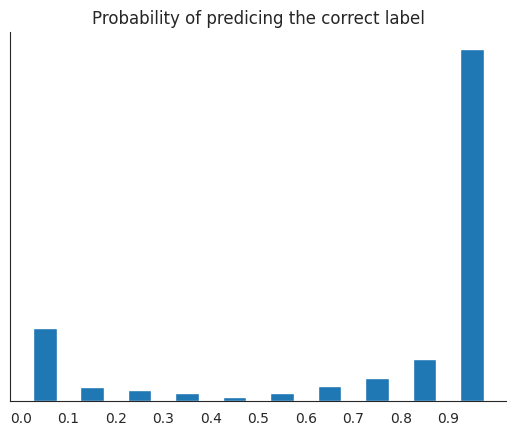

In [218]:
sns.set_style('white')
ax = plt.gca()

bins = np.linspace(0, 1, 11)
bincenters = 0.5*(bins[1:]+bins[:-1])
counts_in_bin, bin_edges = np.histogram(rel_pred_prob_, bins=bins)

# Assign to probabiltiy bins by mean prediction
bin_in_mat = np.digitize(rel_pred_prob_, bins, right=False)

# Get the mean standard deviation for each item in each bin
# (full_pred_prob.max(axis=0).values - full_pred_prob.min(axis=0).values).shape
yerr = [full_pred_prob.std(axis=0)[bin_in_mat == i].mean().cpu().numpy() for i in range(1, 11)]

ax.bar(bincenters, counts_in_bin, width=0.05, yerr=yerr)
ax.set_xticks(bins[:-1])
ax.set_yticks([])
ax.set_title('Probability of predicing the correct label')

sns.despine()

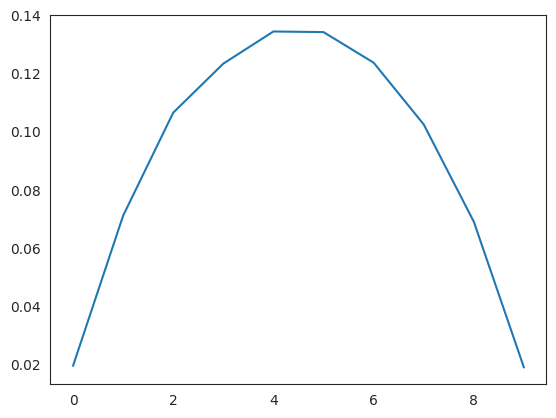

In [203]:
ax = plt.gca()

ax.plot(yerr)

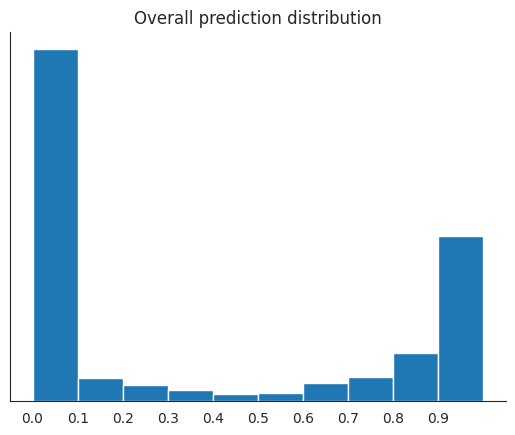

In [160]:
sns.set_style('white')

ax = plt.gca()

bins = np.linspace(0, 1, 11)
ax.set_xticks(bins[:-1])
ax.set_yticks([])
ax.set_title('Overall prediction distribution')
ax.hist(pred_prob_, bins=bins)

sns.despine()

In [88]:
tn, fp, fn, tp = confusion_matrix(valid_y_, pred_label_).ravel()

print('True pos: {} False pos: {} True neg: {} False neg: {}'.format(tp, fp, tn, fn))
# 86% of the items we predicted to be positve are positive, we found 69% of positve examples
print('Precision: {} Recall: {}'.format(tp/(tp+fp), tp/(tp+fn)))

True pos: 798 False pos: 123 True neg: 1030 False neg: 355
Precision: 0.8664495114006515 Recall: 0.6921075455333912


Entropy of correct predictions: 2.843907291663096
Entropy of incorrect predictions: 2.900778913885792


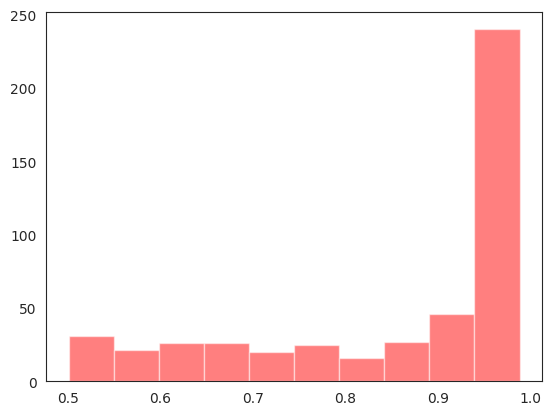

In [107]:
ax = plt.gca()

bins = np.linspace(0, 1, 11)

#n_c, _, _ = ax.hist(pred_prob_correct_, color='g', alpha=0.5)
n_ic, _, _ = ax.hist(pred_prob_incorrect_, color='r', alpha=0.5)

norm_bins_c = (n_c / pred_prob_correct_.shape[0]) + 0.1  # Smoothing
entropy_c = - (norm_bins_c * np.log(norm_bins_c)).sum()
print('Entropy of correct predictions: {}'.format(entropy_c))

norm_bins_ic = (n_ic / pred_prob_incorrect_.shape[0]) + 0.1  # Smoothing
entropy_ic = - (norm_bins_ic * np.log(norm_bins_ic)).sum()
print('Entropy of incorrect predictions: {}'.format(entropy_ic))

#_ = plt.hist(pred_prob_, bins=bins)

NameError: name 'bins' is not defined

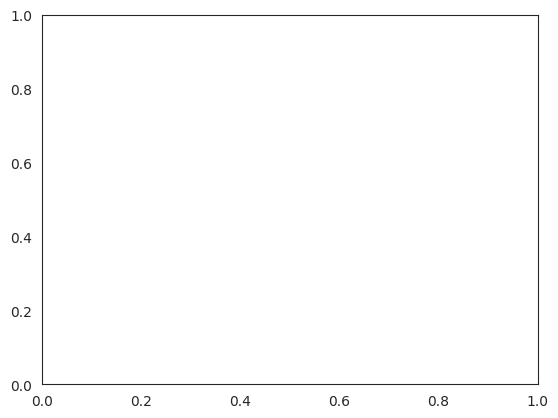

In [61]:
sns.set_style('white')
ax = plt.gca()
ax.plot(bins[:-1], norm_bins_c, marker='o', c='g', label='Correct predictions')
ax.plot(bins[:-1], norm_bins_ic, marker='o', c='r', label='Incorrect predictions')

ax.set_xticks(bins[::2])

ax.legend(frameon=False)
sns.despine()

In [64]:
#pca = PCA(n_components=2)
#x_proj_pca = pca.fit_transform(test_x)
valid_x_ = valid_x.detach().cpu().numpy()
x_proj_tsne = TSNE(n_components=2, perplexity=30).fit_transform(valid_x_)
x_proj_tsne_drugs = TSNE(n_components=2, perplexity=30).fit_transform(valid_x_[:, :512])
x_proj_tsne_diseases = TSNE(n_components=2, perplexity=30).fit_transform(valid_x_[:, 512:])

In [65]:
mode = 'both'  # @param ['both', 'diseases', 'drugs']


if mode == 'diseases':
  x = x_proj_tsne_diseases
elif mode == 'drugs':
  x = x_proj_tsne_drugs
else:
  x = x_proj_tsne

how_many = 20

df = pd.DataFrame({
    'tsne_x': x[:, 0],
    'tsne_y': x[:, 1],
    'drug': valid_names[:, 0],
    'drug_counter': np.zeros_like(valid_names[:, 0]),
    'disease': valid_names[:, 1],
    'disease_counter': np.zeros_like(valid_names[:, 0]),
})

unique_diseases = np.unique(valid_names[:, 1])
disease_counter = collections.Counter(valid_names[:, 1])
most_common_diseases, count_diseases = zip(*disease_counter.most_common()[:how_many])

unique_drugs = np.unique(valid_names[:, 0])
drug_counter = collections.Counter(valid_names[:, 0])
most_common_drugs, count_drugs = zip(*drug_counter.most_common()[:how_many])

print('{} unique drugs, {} unqiue diseases'.format(len(unique_drugs), len(unique_diseases)))

for k, v in disease_counter.items():
  df.loc[df['disease'] == k, 'disease_counter'] = v

for k, v in drug_counter.items():
  df.loc[df['drug'] == k, 'drug_counter'] = v

# Get the mean
df_centres = df.groupby('disease').mean(['tsne_x', 'tsne_y'])

725 unique drugs, 165 unqiue diseases


In [66]:
df

,tsne_x,tsne_y,drug,drug_counter,disease,disease_counter
0,-20.248526,-40.529125,Fosinopril,2,hypertension,109
1,-22.981773,-37.477421,Imidapril,2,hypertension,109
2,-22.026283,-39.604401,Cilazapril,2,hypertension,109
3,-22.447691,-33.357265,Amlodipine,2,hypertension,109
4,-21.051256,-40.100044,Trandolapril,2,hypertension,109
...,...,...,...,...,...,...
2301,23.542830,-20.685369,Arsenic trioxide,2,non-small cell lung carcinoma (disease),25
2302,2.933875,-29.835333,Nusinersen,2,pancreatic insulinoma,10
2303,28.679258,22.669971,Alirocumab,2,lichen planus,8
2304,1.344416,12.014365,Migalastat,4,iron metabolism disease,10


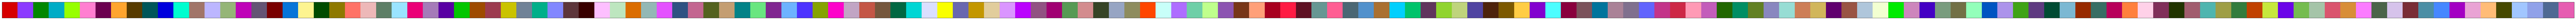

In [67]:
from sklearn.datasets import make_blobs
import colorcet as cc

blobs, labels = make_blobs(n_samples=1000, centers=len(unique_diseases), center_box=(-100, 100))
custom_palette = sns.color_palette(cc.glasbey, n_colors=len(unique_diseases))
diseases_to_colors = dict(zip(unique_diseases.tolist(), custom_palette))

sns.palplot(custom_palette)

blobs, labels = make_blobs(n_samples=1000, centers=len(unique_drugs), center_box=(-100, 100))
custom_palette = sns.color_palette(cc.glasbey, n_colors=len(unique_drugs))
drugs_to_colors = dict(zip(unique_drugs.tolist(), custom_palette))

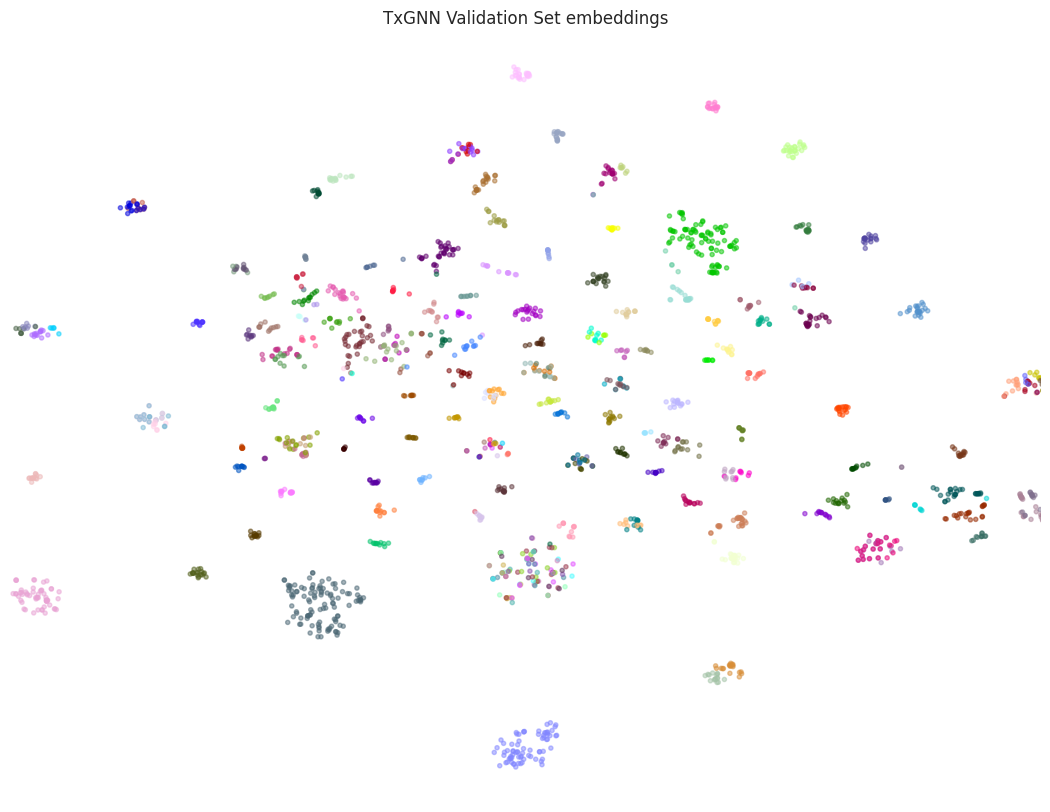

In [68]:
sns.set_style('white')

from matplotlib.lines import Line2D
df_centres = df.groupby('disease').mean(['tsne_x', 'tsne_y'])

with_names = False # @param {type:"boolean"}

colors = [diseases_to_colors[valid_names[i, 1]] for i in range(x_proj_tsne.shape[0])]
markers = list(Line2D.markers.keys())

#colors = sns.color_palette("Paired", 10)

_, ax = plt.subplots(figsize=(1.33*10, 10))
ax.scatter(x[:, 0], x[:, 1], c=colors, marker='.', alpha=0.5)

ax.set_xlim([-50, 50])

if with_names:
  already_used = []
  for i in range(x.shape[0]):
    name = valid_names[i, 1]
    if name in most_common_diseases:
      if name not in already_used:
        print(name)
        x_adj, y_adj = 2, 2
        xy = (df_centres['tsne_x'][name]+x_adj, df_centres['tsne_y'][name]+y_adj)
        ax.annotate(name, xy=xy, fontsize=7, c=colors[i], weight='bold')
        ax.scatter(xy[0], xy[1], c=colors[i], marker='.', label=name)
        already_used.append(valid_names[i, 1])
        #print('{}, {}'.format(test_names[i, 1], xy))

ax.set_title('TxGNN Validation Set embeddings')
ax.set_xticks([])
ax.set_yticks([])
#ax.legend(ncols=2, frameon=False)
ax.set_xlim([-55, 55])
sns.despine(left=True, bottom=True)

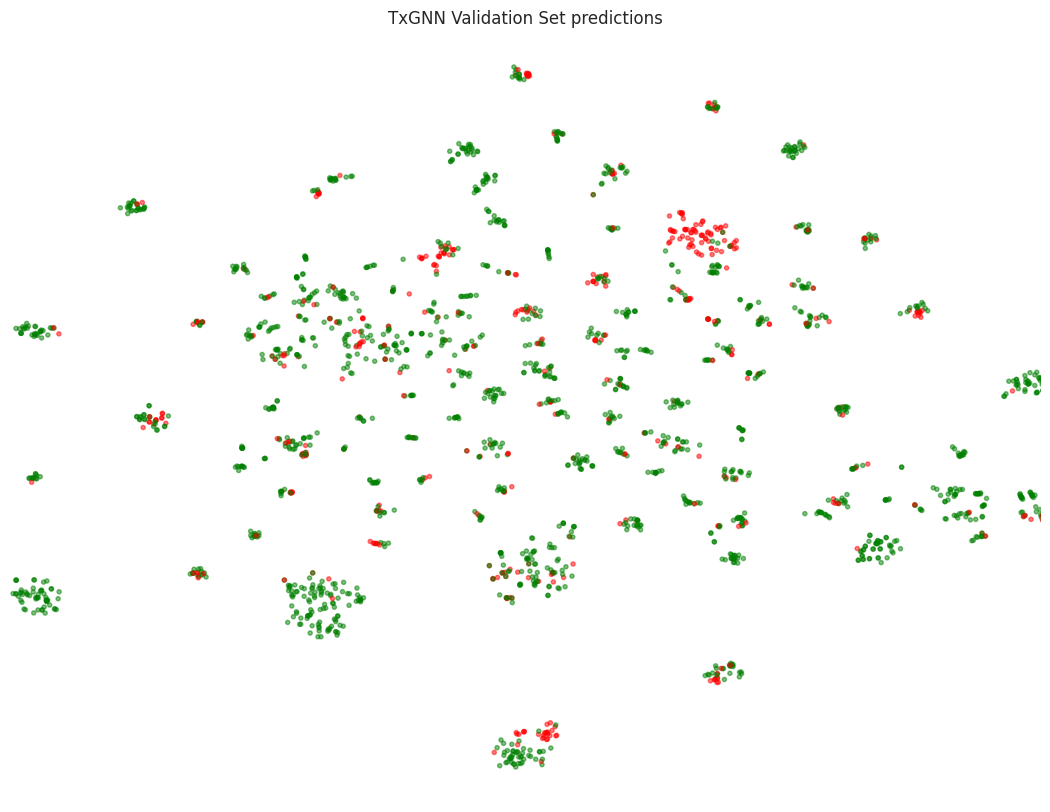

In [69]:
sns.set_style('white')

_, ax = plt.subplots(figsize=(1.33*10, 10))
colors = ['g' if pred_label_[i] == valid_y_[i] else 'r' for i in range(x_proj_tsne.shape[0])]
ax.scatter(x_proj_tsne[:, 0], x_proj_tsne[:, 1], c=colors, marker='.', alpha=0.5)

#ax.legend()
ax.set_xticks([])
ax.set_yticks([])
sns.despine()


ax.set_title('TxGNN Validation Set predictions')
ax.set_xticks([])
ax.set_yticks([])
#ax.legend(ncols=2, frameon=False)
ax.set_xlim([-55, 55])
sns.despine(left=True, bottom=True)